#### Import packages, set directories and parameters

In [81]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shutil
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
import math
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
import collections
from scipy.stats import chi2, binom
from Comparative_Analysis import Alignment as alignfn
from Bio.Align.Applications import MuscleCommandline
import subprocess
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
project_dir = 'F:/Project_Data/mabR_Project/MTBC'
seq_dir = 'F:/Datasets/Other_Genomes/MTBC'
motif_loc = 'F:/Project_Data/mabR_Project/Second_MEME_Upstream_Output/meme.txt'
full_run = True
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'

In [6]:
tbc_seq_dict = {}
tbc_name_dict = {}
tbc_species_dirs = util.list_dirs(seq_dir)
for sdir in tbc_species_dirs:
    for genome_record in SeqIO.parse(seq_dir + '/' + sdir + '/sequence.gb', "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            tbc_name_dict[accession_ver] = genome_record.annotations['organism']
            full_sequence = str(genome_record.seq)
            tbc_seq_dict[accession_ver] = full_sequence
    

In [206]:
informal_names_dict = {'CP063804.2': 'M.orygis', 'CP016401.1':'M.caprae',  'LT708304.1': 'M.bovis', 'AL123456.3':'M.tb', 'LR882500.1': 'M.microti' , 'FR878060.1':'M.africanum', 'HE572590.1':'M.canettii'}

In [200]:
for k, v in tbc_seq_dict.items():
    print(k, tbc_name_dict[k], len(v))

CP063804.2 Mycobacterium orygis 4352140
CP016401.1 Mycobacterium tuberculosis variant caprae 4324961
LT708304.1 Mycobacterium tuberculosis variant bovis AF2122/97 4349904
AL123456.3 Mycobacterium tuberculosis H37Rv 4411532
LR882500.1 Mycobacterium tuberculosis variant microti 4384561
FR878060.1 Mycobacterium tuberculosis variant africanum GM041182 4389314
HE572590.1 Mycobacterium canettii CIPT 140010059 4482059


In [96]:
util.produce_fasta_file([[k,v] for k, v in tbc_seq_dict.items()], project_dir + '/tbc_sequences.faa')

100%|██████████| 7/7 [00:00<00:00, 10.88it/s]


In [97]:
blastfn.run_fimo(motif_loc, project_dir + '/tbc_sequences.faa' , project_dir + '/tbc_FIMO_Hits')

In [98]:
tbc_fimo_hits_df = pd.read_csv(project_dir + '/tbc_FIMO_Hits/fimo.tsv', sep='\t')

In [147]:
temp = []
for i, r in tbc_fimo_hits_df.iterrows():
    if '#' in r['motif_id'] or not(r['motif_alt_id'] == 'MEME-1') or r['q-value'] > 1e-3:
        continue
    start = int(r['start'])-100
    stop = int(r['stop'])+100
    if r['strand'] == 1:
        strand = '+'
    else:
        strand = '-'
    temp.append([r['sequence_name']+'@'+str(start)+'_'+str(stop)+'_'+strand, tbc_seq_dict[r['sequence_name']][start:stop]])

util.produce_fasta_file(temp, project_dir + '/mtbc_fimo_hits.faa')
print(len(temp))

100%|██████████| 1049/1049 [00:00<00:00, 59253.71it/s]

1049


In [148]:
if 1==1:
    blastfn.build_blast_db(project_dir, 'tbc_sequences.faa', 'MTBC', project_dir + '/BLAST/MTBC', 'nucl')
    shutil.copy(project_dir + '/mtbc_fimo_hits.faa', project_dir + '/BLAST/MTBC/mtbc_fimo_hits.faa')
    blastfn.run_blastn(project_dir + '/BLAST/MTBC', 'mtbc_fimo_hits.faa', 'MTBC', 'motif_mtbc_blast_hits.csv', e_value = 1e-1)

In [209]:
blast_results_df = pd.read_csv(project_dir + '/BLAST/MTBC/motif_mtbc_blast_hits.csv', header = None)
blast_results_df.columns = ['query_ref', 'target_ref', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 
                         'query_start_alignment', 'query_end_alignment', 'target_start_alignment', 'target_end_alignment', 'e_value', 'bit_score']
blast_results_df = blast_results_df.loc[blast_results_df.groupby(['query_ref','target_ref'])['bit_score'].idxmax()]
for i, r in blast_results_df.iterrows():
    target_ref = r['target_ref'].split('@')[0]
    informal_target_ref = informal_names_dict[target_ref]
    query_ref = r['query_ref'].split('@')[0]
    blast_results_df.at[i,'query_organism'] = tbc_name_dict[query_ref]
    blast_results_df.at[i,'target_organism'] = tbc_name_dict[target_ref]
    temp = r['query_ref'].split('@')[1].split('_')
    query_start = int(temp[0])
    query_end = int(temp[1])
    target_start_alignment = int(r['target_start_alignment'])
    target_end_alignment = int(r['target_end_alignment'])
    query_start_alignment = int(r['query_start_alignment'])
    query_end_alignment = int(r['query_end_alignment'])
    full_target_alignment_start = target_start_alignment - query_start_alignment 
    full_target_alignment_end = target_end_alignment + 221- query_end_alignment
    blast_results_df.at[i, 'full_target_alignment_start'] =  full_target_alignment_start
    blast_results_df.at[i, 'full_target_alignment_end'] =  full_target_alignment_end
    blast_results_df.at[i, 'full_query_sequence'] =  tbc_seq_dict[query_ref][query_start:query_end]
    blast_results_df.at[i, 'full_target_sequence'] =  tbc_seq_dict[target_ref][full_target_alignment_start: full_target_alignment_end]
    blast_results_df.at[i, 'full_target_sequence_ref'] = target_ref + '_'+ str(full_target_alignment_start) + '_' + str(full_target_alignment_end)
    blast_results_df.at[i, 'informal_target_sequence_ref'] = informal_target_ref + '_'+ str(full_target_alignment_start) + '_' + str(full_target_alignment_end)

In [210]:
blast_results_df.to_csv(project_dir + '/processed_blast_results.csv')

In [211]:
temp_df = blast_results_df.query('query_end_alignment < 217')
distinct_clusters = []
regions_considered = []
for i, r in temp_df.iterrows():
    temp_df_2 = temp_df[temp_df['query_ref'] == r['query_ref']]
    matched = 0
    for j, s in temp_df_2.iterrows():
        for (species, start, stop) in regions_considered:
            if s['target_ref'] == species and s['full_target_alignment_start'] < stop and s['full_target_alignment_end'] > start:
                matched = 1
    if matched == 0:
        distinct_clusters.append(r['query_ref'])
        for j, s in temp_df_2.iterrows():
            regions_considered.append((s['target_ref'], s['full_target_alignment_start'], s['full_target_alignment_end'])) 

In [212]:
for ref in distinct_clusters:
    region_of_interest = blast_results_df.query('query_ref == @ref')
    temp = []
    for i, r in region_of_interest.iterrows():
        temp.append([r['informal_target_sequence_ref'],r['full_target_sequence']])
    util.produce_fasta_file(temp, project_dir + '/Regions_of_Interest/' + ref + '.faa')
    cline = MuscleCommandline(muscle_exe, input= project_dir + '/Regions_of_Interest/' + ref + '.faa', out = project_dir + '/Regions_of_Interest/' + ref + '_aligned.fasta')
    stdout, stderr = cline()

100%|██████████| 7/7 [00:00<?, ?it/s]


In [160]:
util.produce_fasta_file([['H37RV_2522064_2522460',tb_sequence[2522064:2522460]],['AF221297_2505723_2505831',bovis_sequence[2505623:2505931]]], project_dir + '/bovis_tb_difference.faa')

100%|██████████| 2/2 [00:00<?, ?it/s]


In [83]:
cline = MuscleCommandline(muscle_exe, input= project_dir + '/bovis_tb_difference.faa', out = project_dir + '/bovis_tb_alignment.fasta')
stdout, stderr = cline()

In [76]:
bovis_sequence[2505623:2505931]

'CGACGAGAAGATCGACCCGGCGCATACTCGCAGCAAGCTCACCGAGGCGCTGGCGCAGGCTCCGGCACGGCGCGGCCGCCACAAGAACATCCCGCTGTAGTTCTGACCGCGAGCCGCTCCTCGCATGCTCGAACGGTGCCTACCGACGCGCTAACAATTCTCGAGAAGGCCGGCGGGTTCGCCACCACCGCGCAATTGCTCACGGTCATGACCCGCCAACAGCTCGACGTCCAAGTGAAAAACGGCGGCCTCGTTCGCGTTTGGTACGGGGTCTACGCGGCACAAGAGCCGGACCTGTTGGGCCGCTT'

In [165]:
counts_df = blast_results_df.groupby(['query_ref']).size().reset_index()
counts_df=counts_df.rename(columns={0 : 'Count'}) 

#####  Analyse CRyPTIC 

In [62]:
if 1 == 1:
    lineage_dict = {}
    genome_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/GENOMES.csv') 
    for i, r in genome_df.iterrows():
        lineage_dict[r['UNIQUEID']] = (r['MYKROBE_LINEAGE_NAME_1'], r['MYKROBE_LINEAGE_NAME_2'])

C:\Users\nicho\AppData\Local\Temp/ipykernel_16552/834464025.py:3: DtypeWarning: Columns (1,3,13,14,15,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  genome_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/GENOMES.csv')


In [7]:
if 1==0:
    variant_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/VARIANTS.csv') 
    with open(project_dir + '/variant_df.pkl', 'wb') as f:
        pickle.dump(variant_df[['UNIQUEID', 'VARIANT', 'MUTATION_TYPE', 'IS_NULL', 'IS_HET', 'IS_FILTER_PASS', 'IS_INDEL', 'REF', 'ALT', 'GENOME_INDEX']], f)    

C:\Users\nicho\AppData\Local\Temp/ipykernel_16552/3028569424.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  variant_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/VARIANTS.csv')


In [8]:
if 1 == 0:
    position_dict = {}
    variant_dict = {}
    id_dict = {}
    with open(project_dir + '/variant_df.pkl', 'rb') as f:
        variant_df = pickle.load(f) 
        unique_ids = variant_df.UNIQUEID.unique()
        for i, unique_id in enumerate(unique_ids):
            id_dict[unique_id] = i

        for i, r in variant_df.iterrows():
            if r['IS_NULL'] == False and r['IS_FILTER_PASS'] == True and r['IS_HET'] == False and r['IS_INDEL'] == True :
                
                if id_dict[r['UNIQUEID']] in variant_dict:
                    variant_dict[id_dict[r['UNIQUEID']]].append((r['GENOME_INDEX'], r['REF'], r['ALT']))
                else:
                    variant_dict[id_dict[r['UNIQUEID']]] = [(r['GENOME_INDEX'], r['REF'], r['ALT'])]

                if r['GENOME_INDEX'] in position_dict:
                    position_dict[r['GENOME_INDEX']].append((id_dict[r['UNIQUEID']], r['ALT']))
                else:
                    position_dict[r['GENOME_INDEX']] = [r['REF'], (id_dict[r['UNIQUEID']], r['ALT'])]    # If first entry also include reference value for info

    with open(project_dir + '/id_dict.pkl', 'wb') as f:
        pickle.dump(id_dict, f)
    with open(project_dir + '/variant_dict.pkl', 'wb') as f:
        pickle.dump(variant_dict, f) 
    with open(project_dir + '/position_dict.pkl', 'wb') as f:
        pickle.dump(position_dict, f) 
        

In [59]:
unique_id_ref_dict = {}
for k, v in id_dict.items():
    unique_id_ref_dict[v] = k

In [163]:
mite_position_unique_ids_for_position_dict = {}
all_mite_ids = []
for k, v in position_dict.items():
    if len(v[0]) <= 5:
        for u in v[1:]:
            if len(u[1]) > 10 and 'cgagcagacg' in u[1]:
                all_mite_ids.append(unique_id_ref_dict[u[0]])
                if k in mite_position_unique_ids_for_position_dict:
                    mite_position_unique_ids_for_position_dict[k].append(unique_id_ref_dict[u[0]])
                else:
                    mite_position_unique_ids_for_position_dict[k] = [unique_id_ref_dict[u[0]]]

In [165]:
if 1 == 1:
    mite_ids = mite_position_unique_ids_for_position_dict[3423249]
    phenotypes_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/UKMYC_PHENOTYPES.csv') 
    for i, r in phenotypes_df.iterrows():
        uniqueid = r['UNIQUEID']
        if uniqueid in all_mite_ids:   #mite_ids or all_mite_ids for all
            phenotypes_df.at[i, 'MITE'] = 'Y'
        else:
            phenotypes_df.at[i, 'MITE'] = 'N'

In [166]:
len(all_mite_ids)

68669

In [171]:
a= phenotypes_df[phenotypes_df['MITE'] == 'Y']
a.to_csv(project_dir + '/nick.csv')

ConversionError: Failed to convert value(s) to axis units: 317       S
3432      S
4938      S
6366      S
7745      S
         ..
212171    S
216681    S
220877    S
226338    S
227163    S
Name: x, Length: 116, dtype: object

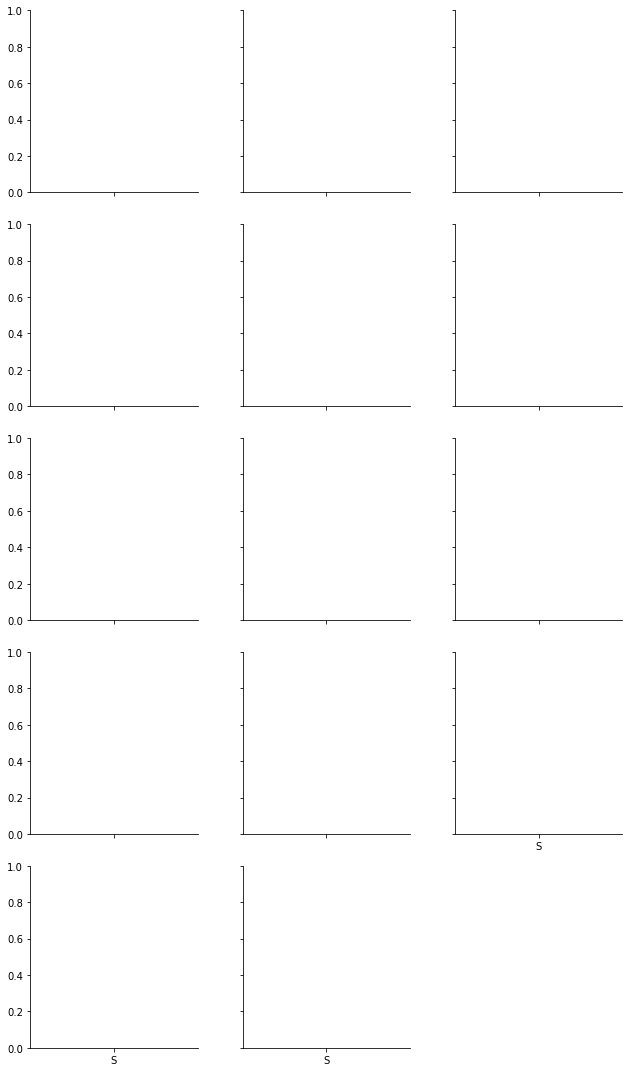

In [169]:
temp_df = phenotypes_df[phenotypes_df['MITE']=='Y']
g = sns.FacetGrid(temp_df, col="DRUG", col_wrap=3)
g.map(sns.histplot, 'BINARY_PHENOTYPE')

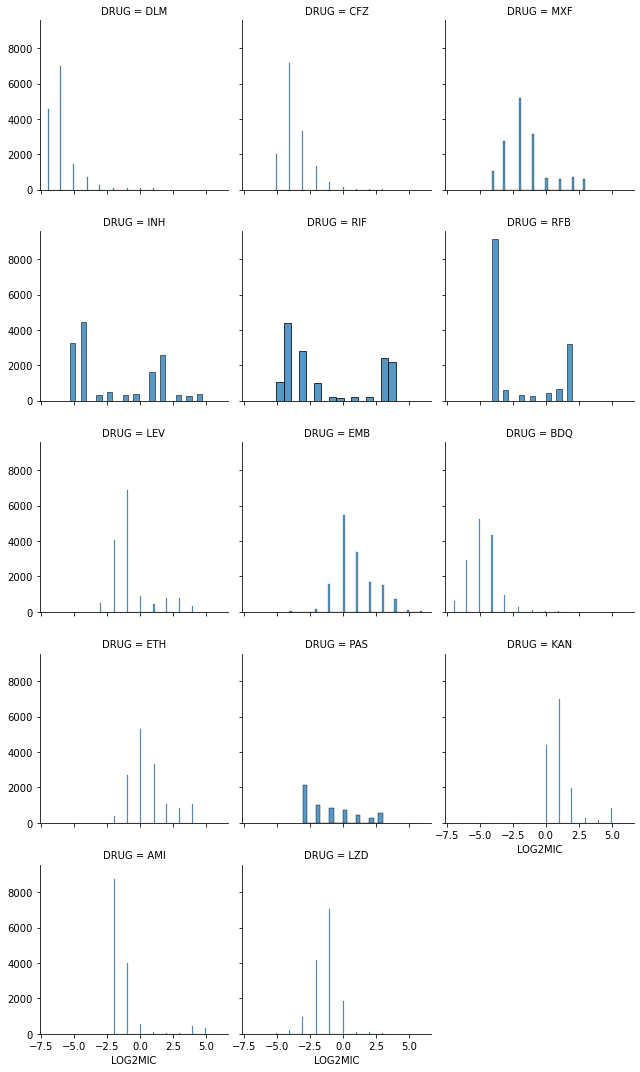

In [146]:
temp_df = phenotypes_df[phenotypes_df['MITE']=='N']
g = sns.FacetGrid(temp_df, col="DRUG", col_wrap=3)
g.map(sns.histplot, 'LOG2MIC')
#sns.histplot(data = phenotypes_df[phenotypes_df['MITE']=='N'], x = 'LOG2MIC', hue = 'MITE', stat = 'count')

In [ ]:
counter_1 = collections.Counter([x[0] for x in mite_position_variant_dictionary[2352065]])
lineage_variant_count_dict = dict(counter_1)
temp = []
for k, v in lineage_dict.items():
    temp.append(v)
counter = collections.Counter([x[0] for x in temp])
for k, v in dict(counter).items():
    if k in lineage_variant_count_dict:
        print(k, v, lineage_variant_count_dict[k])
    else:
        print(k, v, 0)

In [ ]:
for k, v in position_dict.items():
    print(unique_id_ref_dict[k], v)
    break

In [54]:
for k, v in position_dict.items():
    if len(v[0]) == 1 and len(v[1][1]) > 10 and 'cgagcagacg' in v[1][1]:
        print(k, v[0], v[1], len(v))

3423249 c (289, 'cgcgagcagacgcagaatcgcccaaaatccaagattttgaggcgattctg') 44798
2352065 c (1154, 'cctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtg') 23805
2352071 c (5425, 'ctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcgggg') 293
2352067 t (30845, 'tcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtc') 2
2352070 c (33313, 'cctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcggg') 2
2352069 g (40060, 'gcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcgg') 3
2352066 c (49216, 'ctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgt') 2


In [37]:
temp = []
for k, v in position_dict.items():
    if len(v[1][1]) <= 3 and len(v[0]) > 10 and 'cgagcagacg' in v[0]:
        temp.append((k, v[0], v[1], len(v)))

temp.sort(key=lambda x: x[0])
for item in temp:
    print(item)

(234430, 'gtgcccgccgccatccgccgagcagacgcagaatcgcccatttggtatcc', (29987, 'g'), 8)
(234432, 'gcccgccgccatccgccgagcagacgcagaatcgcccatttggtatccca', (6213, 'gt'), 4)
(234440, 'ccatccgccgagcagacgcagaatcgcccatttggtatcccaaatgggcg', (19098, 'cgt'), 2)
(234443, 'tccgccgagcagacgcagaatcgcccatttggtatcccaaatgggcgatt', (41628, 't'), 2)
(456178, 'gcgcaaccgcgctagcacgggccggcgagcagacgcaaaatcgcacggtt', (65552, 'g'), 2)
(456183, 'accgcgctagcacgggccggcgagcagacgcaaaatcgcacggtttgcgg', (31357, 'a'), 2)
(456185, 'cgcgctagcacgggccggcgagcagacgcaaaatcgcacggtttgcggtt', (5341, 'c'), 143)
(459380, 'cttccacgccgagcagacgaggaatcgcactgcgcggacctcacgcgtgc', (17390, 'c'), 6)
(558810, 'ctagtctgccgagcagacgcaaaagcacccttttgcggcgcaaaagtggc', (21568, 'c'), 3)
(558812, 'agtctgccgagcagacgcaaaagcacccttttgcggcgcaaaagtggcgc', (6277, 'a'), 45)
(663367, 'gttctgacggcggctcccatggcgcgagcagacgcagaatcgcacaaaat', (31073, 'g'), 6)
(663368, 'ttctgacggcggctcccatggcgcgagcagacgcagaatcgcacaaaatc', (43279, 't'), 4)
(663373, 'acggcggctcccatggcgcgagcagac

In [162]:
for k, v in position_dict.items():
    if len(v[0]) <= 5:
        ct = 0
        for u in v[1:]:
            if len(u[1]) > 10 and 'cgagcagacg' in u[1]:
                ct +=1
        if ct > 0:
            print(k, v[0], v[1], len(v))

3423249 c (289, 'cgcgagcagacgcagaatcgcccaaaatccaagattttgaggcgattctg') 44798
2352065 c (1154, 'cctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtg') 23805
2352071 c (5425, 'ctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcgggg') 293
4088249 gc (15520, 'g') 3
2352062 ccgc (16568, 'cgtctg') 4
234431 tg (19634, 't') 6
3423250 gcg (19988, 'g') 6
2352067 t (30845, 'tcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtc') 2
2352070 c (33313, 'cctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcggg') 2
2352063 cgc (33948, 'ctcctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcg') 3
2352069 g (40060, 'gcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgtcgg') 3
2352066 c (49216, 'ctcgcctgggctggcgagcagacgcaaaatcccccgcacgcccggcgtgt') 2
